In [1]:
#http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [40]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests, zipfile, io
import time

plt.ion()   # interactive mode

In [25]:
print ("torch.cuda.is_available()", torch.cuda.is_available())

torch.cuda.is_available() True


In [16]:
DATA_DIR = "/home/ec2-user/fastai/courses/dl1/data"
MYDATA_DIR = "/home/ec2-user/fastai/courses/dl1/data/hymenoptera_data/"

DATA_URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [17]:
os.chdir(DATA_DIR)

if os.path.isdir(MYDATA_DIR):
    print ("dir {}  exists, don't need to download zip file again.".format(MYDATA_DIR))
else:
    r = requests.get(DATA_URL)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

In [19]:
print ("start")
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


start


In [20]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs: <class 'torch.FloatTensor'>
classes: <class 'torch.LongTensor'>
out: <class 'torch.FloatTensor'>


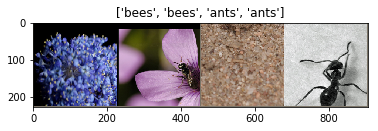

In [24]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print ("inputs:", type(inputs))
print ("classes:", type(classes))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print ("out:", type(out))

imshow(out, title=[class_names[x] for x in classes])

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [31]:
model_ft = models.resnet18(pretrained=True)
#downloads the model file.  size = 46827520. does not download again if already existing.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 114203544.36it/s]


In [37]:
print ("type(model_ft):", type(model_ft))
num_ftrs = model_ft.fc.in_features
print ("type(num_ftrs):", type(num_ftrs), num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, 2)
print ("type(model_ft.fc):", type(model_ft.fc))

type(model_ft): <class 'torchvision.models.resnet.ResNet'>
type(num_ftrs): <class 'int'> 512
type(model_ft.fc): <class 'torch.nn.modules.linear.Linear'>


In [39]:
if use_gpu:
    print ("using gpu")
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()
print ("type(criterion):", type(criterion))

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
print ("type(optimizer_ft):", type(optimizer_ft))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
print ("type(exp_lr_scheduler):", type(exp_lr_scheduler))

using gpu
type(criterion): <class 'torch.nn.modules.loss.CrossEntropyLoss'>
type(optimizer_ft): <class 'torch.optim.sgd.SGD'>
type(exp_lr_scheduler): <class 'torch.optim.lr_scheduler.StepLR'>


In [41]:
start = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
end = time.time()
print ("time to execute:".format(end-start))

Epoch 0/24
----------
train Loss: 0.5548 Acc: 0.6803
val Loss: 0.2672 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4502 Acc: 0.8156
val Loss: 0.2836 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5171 Acc: 0.7746
val Loss: 0.3674 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.5745 Acc: 0.7746
val Loss: 0.2794 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4339 Acc: 0.8197
val Loss: 0.4973 Acc: 0.7908

Epoch 5/24
----------
train Loss: 0.4713 Acc: 0.8156
val Loss: 0.3504 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5629 Acc: 0.8115
val Loss: 0.4808 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.5407 Acc: 0.8115
val Loss: 0.2619 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3701 Acc: 0.8443
val Loss: 0.2173 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3562 Acc: 0.8525
val Loss: 0.1963 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3201 Acc: 0.8648
val Loss: 0.1987 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3667 Acc: 0.8730
val Loss: 0.2042 Acc: 0.9085

Ep

In [42]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [43]:
start = time.time()
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
end = time.time()
print ("time to execute:".format(end-start))


Epoch 0/24
----------
train Loss: 0.6009 Acc: 0.6639
val Loss: 0.2702 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.6744 Acc: 0.7008
val Loss: 0.7418 Acc: 0.7582

Epoch 2/24
----------
train Loss: 0.5321 Acc: 0.7787
val Loss: 0.1971 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4987 Acc: 0.8033
val Loss: 0.3938 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5168 Acc: 0.7910
val Loss: 0.2055 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4722 Acc: 0.8115
val Loss: 0.2770 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4687 Acc: 0.8033
val Loss: 0.2587 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3250 Acc: 0.8320
val Loss: 0.2276 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3439 Acc: 0.8525
val Loss: 0.2173 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3239 Acc: 0.8402
val Loss: 0.2160 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3721 Acc: 0.8197
val Loss: 0.3146 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.3375 Acc: 0.8689
val Loss: 0.2451 Acc: 0.9216

Ep

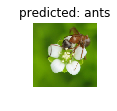

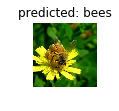

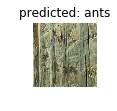

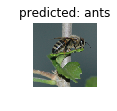

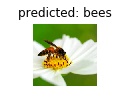

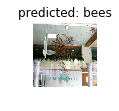

In [44]:
visualize_model(model_conv)

plt.ioff()
plt.show()